## HW6: Regression Analysis

### Author: Seo Won Yi (yiseo)
### Collaborator: Serena Ban (banseri)

In this HW, we will perform


(1) (Univariate) Bayesian Logistic Regression

(2) Derive the Lasso and Ridge regressions using normal and laplace prior distributions

(3) Robust Regression using scale mixture of normals (I didn't do this since I didn't have enough time. I will implement this in the future.)

### Part 1

We will perform a Bayesian Logistic Regression analysis to determine the sex of the penguin using the data from https://www.kaggle.com/datasets/amulyas/penguin-size-dataset/data

In [1]:
# import every necessary modules

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd

# URL for the dataset obtained from https://www.kaggle.com/datasets/amulyas/penguin-size-dataset/data

data_url = "https://raw.githubusercontent.com/woom221/STA365-UofT/main/HW3/data/penguins_size.csv"

# read the dataset

df = pd.read_csv(data_url)

print(len(df.index))

df.head()

344


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [2]:
# detect how many rows contain missing data for each column

df.shape[0] - df.dropna().shape[0]

10

In [3]:
# we can see that the portion of missing data is around 3%
# for this analysis, we will remove them and conduct Complete Case Analysis

df.dropna(axis=0, inplace=True)

print(len(df.index))

df.head(5)

334


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [4]:
# first let's observe the data set

# Observe the column variables

print(list(df))

['species', 'island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']


In [5]:
# observe the unique values in each column

for column in list(df):
  print(df[column].unique())
  print("\n")

['Adelie' 'Chinstrap' 'Gentoo']


['Torgersen' 'Biscoe' 'Dream']


[39.1 39.5 40.3 36.7 39.3 38.9 39.2 41.1 38.6 34.6 36.6 38.7 42.5 34.4
 46.  37.8 37.7 35.9 38.2 38.8 35.3 40.6 40.5 37.9 37.2 40.9 36.4 42.2
 37.6 39.8 36.5 40.8 36.  44.1 37.  39.6 42.3 40.1 35.  42.  34.5 41.4
 39.  35.7 41.3 41.6 35.5 41.8 33.5 39.7 45.8 42.8 36.2 42.1 42.9 35.1
 37.3 36.3 36.9 38.3 34.  38.1 33.1 43.2 41.  45.6 42.7 40.2 35.2 41.5
 38.5 43.1 36.8 37.5 35.6 32.1 40.7 46.5 50.  51.3 45.4 52.7 45.2 46.1
 46.6 51.7 47.  52.  45.9 50.5 50.3 58.  46.4 49.2 42.4 48.5 50.6 46.7
 49.5 52.8 54.2 51.  49.7 47.5 47.6 46.9 53.5 49.  46.2 50.9 45.5 50.8
 50.1 51.5 49.8 48.1 51.4 45.7 50.7 52.2 49.3 50.2 51.9 46.8 55.8 43.5
 49.6 48.7 43.3 48.4 45.1 46.3 47.8 48.2 47.3 59.6 49.1 42.6 44.4 44.
 45.3 43.6 44.9 45.  43.8 50.4 54.3 47.7 48.6 51.1 52.5 47.4 43.4 52.1
 44.5 49.4 55.9 47.2 41.7 53.4 55.1 48.8 49.9]


[18.7 17.4 18.  19.3 20.6 17.8 19.6 17.6 21.2 21.1 19.  20.7 18.4 21.5
 18.3 19.2 18.1 17.2 18.9 18.6 17

In [6]:
# For this analysis, we will use the species Adelie to perform analysis
# Filter the data for Adelie only

df_final = df[df["species"] == "Adelie"]

df_final.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [7]:
# check if the sex is a binary variable here

df_final["sex"].unique()

array(['MALE', 'FEMALE'], dtype=object)

In [8]:
# Convert the target variables to 0 and 1 where 0 represents FEMALE

df_final.loc[:,"encoded_sex"] = (df_final["sex"] == "MALE").astype(int)

df_final.head()

<ipython-input-8-6e3c049c46af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.loc[:,"encoded_sex"] = (df_final["sex"] == "MALE").astype(int)


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,encoded_sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE,1
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE,1


In [9]:
# scale using min_max for the columns ulmen_length_mm, culmen_depth_mm,
# flipper_length_mm that will be used as predictors

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
df_final[['standardized_culmen_length',
    'standardized_culmen_depth',
    'standardized_flipper_length']] = min_max_scaler.fit_transform(
        df_final[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm']])

df_final.head()

<ipython-input-9-29693fab03cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[['standardized_culmen_length',
<ipython-input-9-29693fab03cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[['standardized_culmen_length',
<ipython-input-9-29693fab03cf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,encoded_sex,standardized_culmen_length,standardized_culmen_depth,standardized_flipper_length
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE,1,0.503597,0.533333,0.236842
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,0,0.532374,0.316667,0.368421
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,0,0.589928,0.416667,0.605263
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,0,0.330935,0.633333,0.552632
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE,1,0.517986,0.850000,0.473684


In [10]:
# observe the statistical summary

print(df_final.describe())

       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
count        146.000000       146.000000         146.000000   146.000000   
mean          38.823973        18.347260         190.102740  3706.164384   
std            2.662597         1.219338           6.521825   458.620135   
min           32.100000        15.500000         172.000000  2850.000000   
25%           36.725000        17.500000         186.000000  3362.500000   
50%           38.850000        18.400000         190.000000  3700.000000   
75%           40.775000        19.000000         195.000000  4000.000000   
max           46.000000        21.500000         210.000000  4775.000000   

       encoded_sex  standardized_culmen_length  standardized_culmen_depth  \
count   146.000000                  146.000000                 146.000000   
mean      0.500000                    0.483739                   0.474543   
std       0.501721                    0.191554                   0.203223   
min    

In [42]:
# for this analysis, we will use culmen_length_mm, culmen_depth_mm,
# flipper_length_mm to predict encoded_sex

# choose the predictors and convert them to numpy matrix (146 x 3)
X = df_final[["standardized_culmen_length", "standardized_culmen_depth",
              "standardized_flipper_length"]].values
# choose the response and convert them to numpy matrix (146 X 1)
y = df_final["encoded_sex"].values.reshape(X.shape[0], 1)

# using the summary statistics from above, set up reasonable prior distribution
n = X.shape[0] # number of data
p = X.shape[1] # number of parameter

with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p, 1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.HalfCauchy('sigma', beta=1)
    z = pm.Normal('z', mu=pm.math.dot(X, betas), sigma=sigma)
    y_obs = pm.Bernoulli("y_obs", p=pm.math.sigmoid(z), observed=y)


with MLR:
    idata = pm.sample()

HMC Split-Rhats {'betas': array([[1.0076, 1.023 , 1.0086],
       [1.0132, 1.0085, 1.0002],
       [1.0063, 1.0207, 1.0056]]), 'sigma': 1.0726}


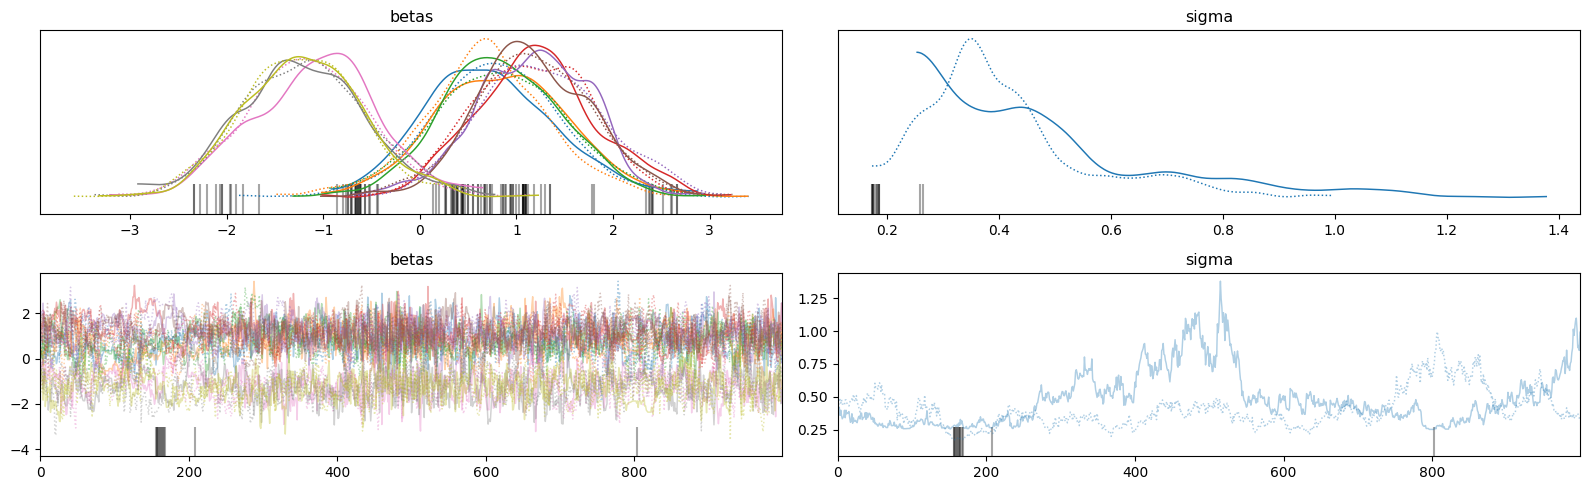

In [44]:
# Check convergence of the chains and check the Rhat value
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata).items() if k != 'z'})
fig,ax = plt.subplots(2,2,figsize=(16,5))
az.plot_trace(idata, var_names=["betas","sigma"], axes=ax.T);
plt.tight_layout();

We observe that the split $\hat{R}$ for $\beta$'s are below 1.05 but we have a slight concern regarding the split $\hat{R}$ for $\sigma$ which indicates our model specification may not correctly represent the data. We may need to have more data to have a better posterior distribution.

### Part 2

We will derive ridge regression and lasso regression from bayesian analysis.

#### (i) Ridge Regression

Assuming

\begin{align*}
 \beta_i \sim {} & \text{Normal}(b_i,s_i) & f(\beta_i| b_i, s_i) = {}& \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{\beta_i-b_i}{s_i}\right)^2} & \overbrace{\underbrace{|\beta_i-b_i|^2}}_{\text{Squared Penalization}}^{L_2} \\
y_i \sim {} & \text{Normal}(x_i^T\beta, \sigma) & \sigma \sim {} & \text{HalfNormal}(\sigma_0)
\end{align*}

First, we assume $\sigma = 1$ and $b_{i} = 0$, then the equation for the posterior distribution of $\beta_{i}$ would look like

\begin{align*}
  p(\beta|y, X, s_{i}) &\propto p(y_{i}|\beta_{i}, X)p(\beta_{i}|s_{i}) \\
  &\propto \prod_{i = 1}^{n} e^{-\frac{1}{2}(y - X_{i}^{T}\beta)^{2}} e^{- \frac{1}{2}(\frac{\beta_{i}}{s_{i}})^{2}} \\
  log(p(\beta|y, X, s_{i})) &\propto log(\prod_{i = 1}^{n} e^{-\frac{1}{2}(y - X_{i}^{T}\beta)^{2}} e^{-\frac{1}{2}(\frac{\beta_{i}}{s_{i}})^{2}}) \\
  &= \sum_{i = 1}^{n}log(e^{-\frac{1}{2}(y - X_{i}^{T}\beta)^{2}} e^{-\frac{1}{2}(\frac{\beta_{i}}{s_{i}})^{2}}) \\
  &= \sum_{i = 1}^{n}log(e^{-\frac{1}{2}(y - X_{i}^{T}\beta)^{2}}) + \sum_{i = 1}^{n}log(e^{-\frac{1}{2}(\frac{\beta_{i}}{s_{i}})^{2}}) \\
  &= -\sum_{i = 1}^{n} \frac{1}{2}(y - X_{i}^{T}\beta)^{2} - \sum_{i = 1}^{n} \frac{1}{2}(\frac{\beta_{i}}{s_{i}})^{2} \\
  &= - (\sum_{i = 1}^{n} \frac{1}{2}(y - X_{i}^{T}\beta)^{2} + \sum_{j = 1}^{n} \frac{1}{2s_{j}^{2}}({\beta_{j}}^{2}))
\end{align*}

If we suppose $\frac{1}{2s_{j}^{2}} = \frac{\lambda}{n}$ for all $j$'s and set up all the $s_{j}$ values accordingly, we get the desired ridge regression.

Notice that the negative sign here makes the distribution to be reflected which makes the minimizing loss function be equivalent to maximizing the posterior distribution.

#### (ii) Lasso Regression

\begin{align*}
\beta_i \sim {} & \text{Laplace}(b_i,s_i) & f(\beta_i| b_i, s_i) = {}& {\frac  {1}{2s_{i}}}\exp \left(-{\frac{|\beta_i-b_i |}{s_i}}\right) & \overbrace{\underbrace{|\beta_i-b_i|}}_{\text{Absolute Penalization}}^{L_1}\\
y_i \sim {} & \text{Normal}(x_i^T\beta, \sigma) & \sigma \sim {} & \text{HalfNormal}(\sigma_0)
\end{align*}


Using the same approach as the previous derivation, we first assume $\sigma = 1$ and $b_{i} = 0$.

We write the posterior distribution of $\beta$ to be

\begin{align*}
  p(\beta|y, X, s_{i}) &\propto \prod_{i = 1}^{n} e^{-\frac{1}{2}(y - X_{i}^{T}\beta)^{2}} e^{-\frac{|\beta_{i}|}{s_{i}}} \\
  log(p(\beta|y, X)) &\propto log(\prod_{i = 1}^{n} e^{-\frac{1}{2}(y - X_{i}^{T}\beta)^{2}} e^{-\frac{|\beta_{i}|}{s_{i}}}) \\
  &= \sum_{i = 1}^{n}log(e^{-\frac{1}{2}(y - X_{i}^{T}\beta)^{2}} e^{-\frac{|\beta_{i}|}{s_{i}}}) \\
  &= \sum_{i = 1}^{n}log(e^{-\frac{1}{2}(y - X_{i}^{T}\beta)^{2}}) + \sum_{i = 1}^{n}log(e^{-\frac{|\beta_{i}|}{s_{i}}}) \\
  &= -\sum_{i = 1}^{n} \frac{1}{2}(y - X_{i}^{T}\beta)^{2} - \sum_{i = 1}^{n} \frac{|\beta_{i}|}{s_{i}} \\
  &= - (\sum_{i = 1}^{n} \frac{1}{2}(y - X_{i}^{T}\beta)^{2} + \sum_{j = 1}^{n} \frac{1}{s_{j}}{|\beta_{j}|})
\end{align*}

If we suppose $\frac{1}{s_{j}} = \frac{\lambda}{n}$ for all $j$'s and set up all the $s_{j}$ values accordingly, we get the desired lasso regression.

Notice that similarly to the previous argument, the negative sign here makes the distribution to be reflected which makes the minimizing loss function be equivalent to maximizing the posterior distribution.


In conclusion, Bayesian Analysis allow manipulation of the posterior distribution through prior distribution. This is different from optimization as we do not try to maximize likelihood or minimize the loss function, but instead, we simply put "stronger" belief on prior to create a better model.
